In [127]:
import matplotlib.pyplot as plt
import matplotlib
# %matplotlib qt

import numpy as np
from numpy import *
from scipy.fft import fft, ifft, fftshift, ifftshift
from scipy.optimize import curve_fit

import os
import scipy.io as sio

# PSD model: 1/f + 1/f^2 + white noise
def psd_full(f, A1, A2, C):
    return A1 / f + A2 / f**2 + C

# Fitting function
def get_full_fit(x_data, y_data):
    valid = (x_data > 0) & (y_data > 0) & np.isfinite(y_data)
    x_clean = x_data[valid]
    y_clean = y_data[valid]
    params, pcov = curve_fit(psd_full, x_clean, y_clean, maxfev=10000)
    A1, A2, C = params
    a1_err = np.sqrt(pcov[0, 0])
    return A1, A2, C, x_clean, y_clean, a1_err

In [128]:
initial_folder = r'C:\Users\Demag\PycharmProjects\ColdMeasurements\DeMag\DATA\TWPA_noise_9\Best_noise_power_sweep'

folders = os.listdir(initial_folder)
for i in range(len(folders)):
    if ".fig" in folders[i]: pass
    else: 
        print(r"[%d]" %(i), '----------->', folders[i])

[0] -----------> Noise_sweep_10_100_501_2.374_9.205_2025-08-03-10-58-10.mat
[1] -----------> Noise_sweep_10_200_501_1.375_10.71_2025-08-03-03-32-11.mat
[2] -----------> Noise_sweep_10_200_501_1.575_9.225_2025-08-03-05-32-27.mat
[3] -----------> Noise_sweep_10_200_501_1.62_9.189_2025-08-02-23-31-49.mat
[4] -----------> Noise_sweep_10_200_501_1.6_9.144_2025-08-03-01-31-59.mat
[5] -----------> Noise_sweep_10_200_501_2.325_9.162_2025-08-03-07-32-39.mat
[6] -----------> Noise_sweep_10_200_501_2.375_9.207_2025-08-03-09-32-55.mat


In [136]:
file = folders[0]
mat = sio.loadmat(initial_folder+"\\"+file)
print(mat.keys(), '\n')

data_gain = mat['data_gain']
print(data_gain.shape)
volts = mat['volts'][0]
print('DC:', volts.shape)
pump_freqs = mat['pump_freqs'][0]
print('pf:', pump_freqs.shape)
pump_powers = mat['pump_powers'][0]
print('pp', pump_powers.shape)
fft_freq = mat['fft_freq'][0]
print('fft_freq:', fft_freq.shape)


data_mag = mat['data_mag']/len(fft_freq)/100*2 # on/off
print(data_mag.shape)
data_pha = mat['data_pha']/len(fft_freq)/100*2 # on/off
print(data_pha.shape)


dict_keys(['__header__', '__version__', '__globals__', 'pump_powers', 'pump_freqs', 'volts', 'data_gain', 'data_mag', 'data_pha', 'fft_freq']) 

(3, 3, 10)
DC: (3,)
pf: (3,)
pp (10,)
fft_freq: (501,)
(3, 3, 10, 2, 501)
(3, 3, 10, 2, 501)


0 0 6 18.86641 2.373 9204500000.0 -7.152798098746044
0 1 6 19.00473 2.373 9205000000.0 -7.08389923098848
0 2 6 19.19785 2.373 9205500000.0 -7.083965064758278
1 0 7 21.42771 2.374 9204500000.0 -7.2332985727394234
1 1 7 21.76788 2.374 9205000000.0 -7.248062139309923
1 2 7 21.97231 2.374 9205500000.0 -7.2434693179581995
2 0 7 20.08384 2.375 9204500000.0 -7.164750434029461
2 1 7 20.30137 2.375 9205000000.0 -7.159219791685648
2 2 7 20.54088 2.375 9205500000.0 -7.25053487875987


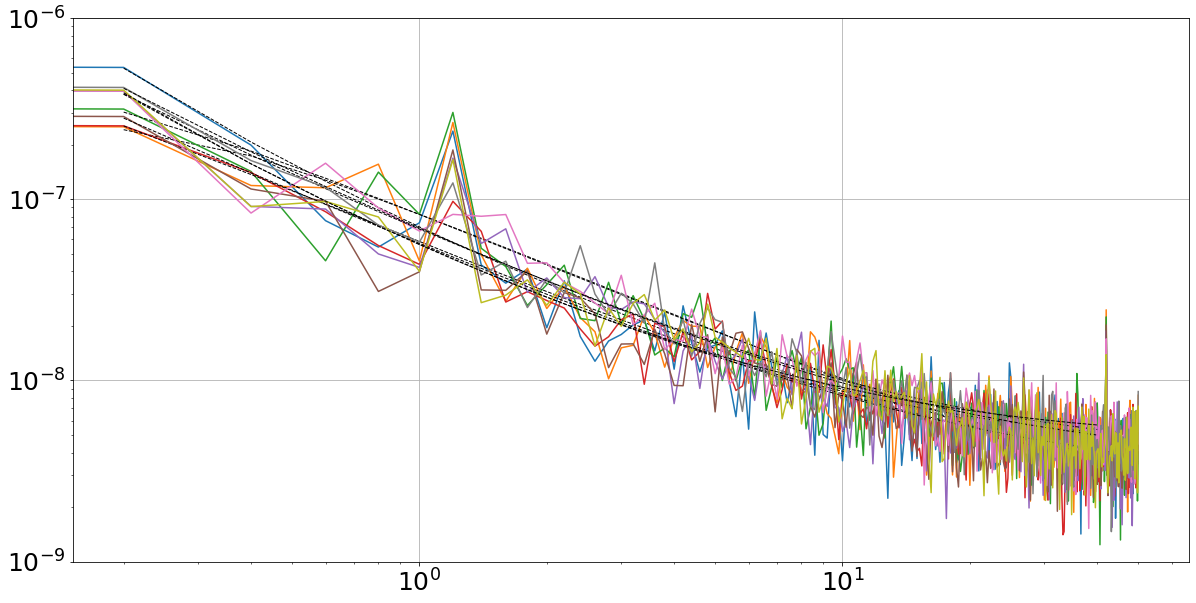

In [151]:
font = {'size': 25}
matplotlib.rc('font', **font)

data_pha_mea = data_pha[:,:,:,0]

fig, ax = plt.subplots(figsize=(20, 10))
ax.set_ylim(10**-9, 10**-6)
ax.grid()
for i in range(len(data_pha_mea)):
    for ii in range(len(data_pha_mea[0])):
        for iii in range(len(data_pha_mea[0,0])):
            data_curr = data_pha_mea[i,ii,iii]
            if data_curr[0]>0:
                A1, A2, C, xc_full, yc_full, a_err = get_full_fit(fft_freq[-250:-50], data_curr[-250:-50])
                y_fit = psd_full(1, A1, A2, C)
                if np.log10(y_fit)<-7. and data_gain[i,ii,iii]>18: 
                    print(i, ii, iii, data_gain[i,ii,iii], volts[i],pump_freqs[ii], np.log10(y_fit))
                    ax.loglog(fft_freq, data_curr)
                    ax.plot(xc_full, psd_full(xc_full, A1, A2, C), 'k--', linewidth=1)

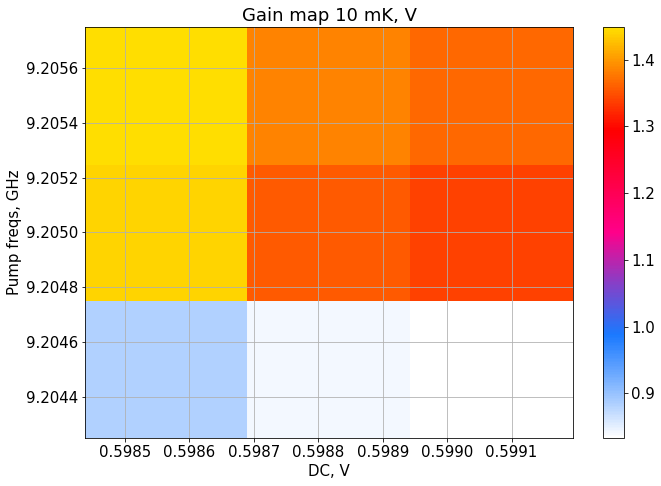

In [138]:
from matplotlib.colors import LinearSegmentedColormap

font = {'size'   : 15}
matplotlib.rc('font', **font)

data0 = data_gain[:,:,0]
data1 = data_gain[:,:,0]
data2 = data_gain[:,:,0]



colors2 = ['#ffffff',  '#006affe5', '#ff008aff', '#ff0000ff', '#ffde00ff']
cmap2 = LinearSegmentedColormap.from_list('my_cmap', colors2, N=256)

fig2, ax = plt.subplots(1, 1, figsize=(10,7), sharex = True, sharey = True)

c1 = ax.pcolor(volts[:]/3.95*1.5/1.5055, pump_freqs / 1e9, data0[:, :].T, cmap=cmap2)
ax.set_title(r'Gain map 10 mK, V')
ax.set_xlabel(r'DC, V')
ax.set_ylabel(r'Pump freqs, GHz')
ax.grid(True)
fig.colorbar(c1, ax=ax, orientation='vertical')


plt.tight_layout()
plt.show()

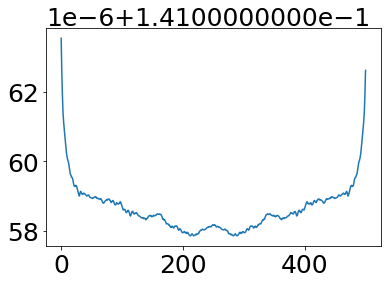

In [158]:
plt.plot(real(ifft(ifftshift(data_mag[1][1][7][0]))))